In [1]:
import os
import time
import umap
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr

from src.datasets import load_dataset, preprocess_dataset, prefetch_dataset
from src.utils import *

2024-02-02 10:39:38.158827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 10:39:38.158889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 10:39:38.158908: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 10:39:38.165951: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## CNN, Fashion MNIST

In [2]:
cfg = { 'dataset' : 'fashion_mnist',
        'model' : 'cnn',
        'batch_size' : 512,
        'optimizer' : 'Adam',
        'learning_rate' : 0.001,
        'max_epoch' : 300,
        'patience' : 10,}    

model_name = cfg['model']
dataset_name = cfg['dataset']

In [3]:
run = 0
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
activity = int_model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
reducer = umap.UMAP(n_components=2)
umap_result = reducer.fit_transform(activity)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
np.save(f'{exp_name}/umap.npy', umap_result)

2024-02-01 11:05:35.006712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78835 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-02-01 11:05:37.683177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


In [3]:
run = 0
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
umap_result = np.load(f'{exp_name}/umap.npy')

2024-02-01 11:14:54.790750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78835 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


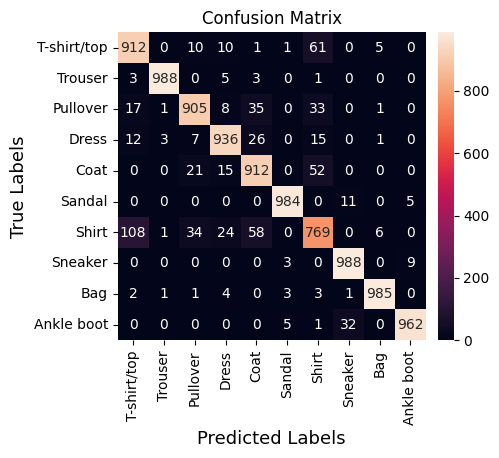

In [7]:
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
cm = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 4), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', square=True, cbar_kws={"pad": 0.02})
plt.xlabel('Predicted Labels', fontsize=13)
plt.ylabel('True Labels', fontsize=13)
class_names = ds_info.features['label'].names
plt.xticks(ticks=np.array(range(len(class_names)))+0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.array(range(len(class_names)))+0.5, labels=class_names, rotation=0)
plt.title('Confusion Matrix')
plt.show()

In [8]:
wrong_preds = np.sum(cm, axis=1) - np.diag(cm)
wrong_preds

array([ 88,  12,  95,  64,  88,  16, 231,  12,  15,  38])

In [8]:
margin_list = []
for x, y in ds_test.batch(512):
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        h_i = tf.reduce_max(logits, axis=1)
    grad_i = tape.gradient(h_i, x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        h_j = tf.convert_to_tensor([tf.math.top_k(logit, 2).values[1] for logit in logits])
    grad_j = tape.gradient(h_j, x)

    margin = (h_i - h_j) / np.linalg.norm(grad_i - grad_j)
    margin_list.extend(list(margin.numpy()))

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
np.save(f'{exp_name}/margin.npy', np.array(margin_list))

### Softmax

In [9]:
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
softmax_val = np.max(preds, axis=1)

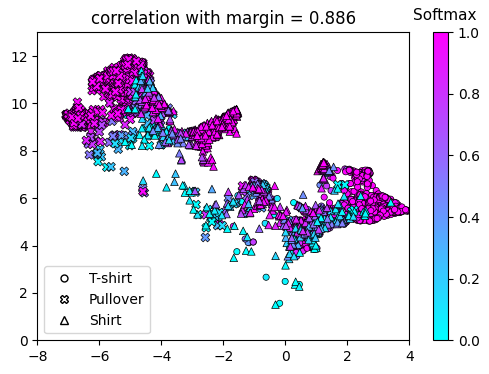

In [15]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,softmax_val)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=preds[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=preds[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=preds[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('Softmax', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

In [18]:
rank_preds = []
for k in range(10):
    softmax_ = preds[:,k]
    idx_sort = np.argsort(np.argsort(softmax_))
    rank_softmax = idx_sort/(len(softmax_)-1)
    rank_preds.append(rank_softmax)
    
rank_preds = np.array(rank_preds).T
rank_softmax = [softmax_value[pred_value] for softmax_value, pred_value in zip(rank_preds, pred_y)]

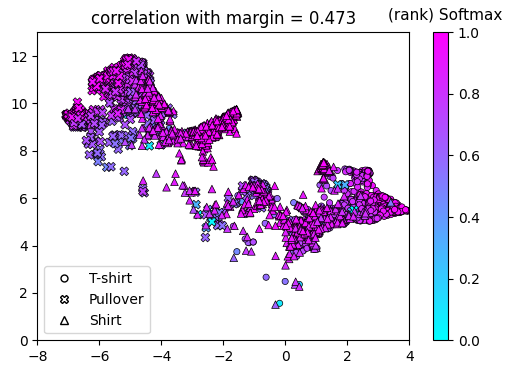

In [19]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_softmax)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_preds[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_preds[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_preds[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) Softmax', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

### PMI

In [4]:
critic = 'separable'
estimator = 'density_ratio_fitting'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
pmi_class = np.load(f'{exp_name}/pmi_class_test.npy')
pmi_class = np.array([softmax(x) for x in pmi_class])
pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(pmi_class, pred_y)]

2024-02-01 11:15:11.916651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


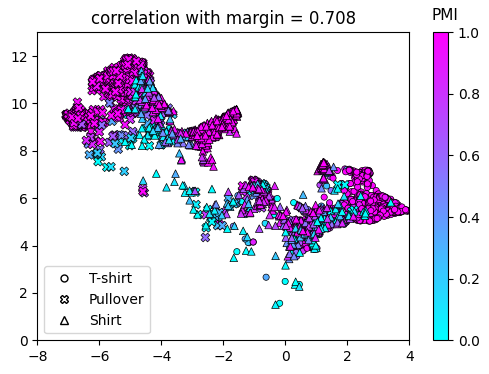

In [8]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,pmi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=pmi_class[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=pmi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=pmi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('PMI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

In [ ]:
rank_pmi_class = []
for k in range(10):
    pmi = pmi_class[:,k]
    idx_sort = np.argsort(np.argsort(pmi))
    rank_pmi = idx_sort/(len(pmi)-1)
    rank_pmi_class.append(rank_pmi)

rank_pmi_class = np.array(rank_pmi_class).T
rank_pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(rank_pmi_class, pred_y)]

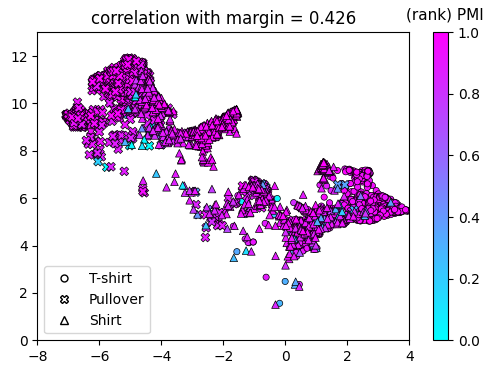

In [9]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_pmi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_pmi_class[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_pmi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_pmi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) PMI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

### PVI

In [3]:
estimator = 'ensemble_training_from_scratch_training_mlp_penultimate'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pvi/{estimator}'
pvi_class = np.load(f'{exp_name}/pvi_class_test.npy')
pvi_class = np.array([softmax(x) for x in pvi_class])
pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(pvi_class, pred_y)]

2024-02-02 10:40:56.659388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78835 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-02-02 10:41:00.980683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906


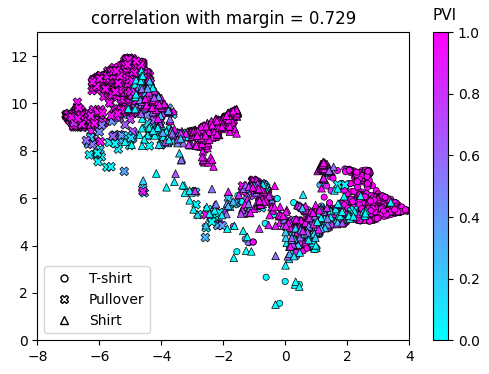

In [6]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,pvi)

umap_result = np.load(f'{exp_name}/umap.npy')

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=pvi_class[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=pvi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=pvi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('PVI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

In [10]:
rank_pvi_class = []
for k in range(10):
    pvi = pvi_class[:,k]
    idx_sort = np.argsort(np.argsort(pvi))
    rank_pvi = idx_sort/(len(pvi)-1)
    rank_pvi_class.append(rank_pvi)

rank_pvi_class = np.array(rank_pvi_class).T
rank_pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(rank_pvi_class, pred_y)]

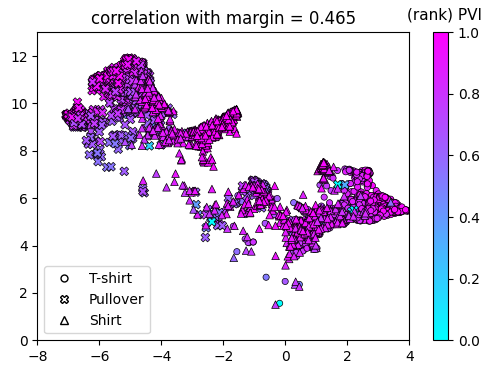

In [11]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_pvi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_pvi_class[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_pvi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_pvi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) PVI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

### PSI

In [7]:
estimator = 'gaussian'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/psi/{estimator}'
psi_class = np.load(f'{exp_name}/psi_class_test.npy')
psi_class = np.array([softmax(x) for x in psi_class])
psi = [psi_value[pred_value] for psi_value, pred_value in zip(psi_class, pred_y)]

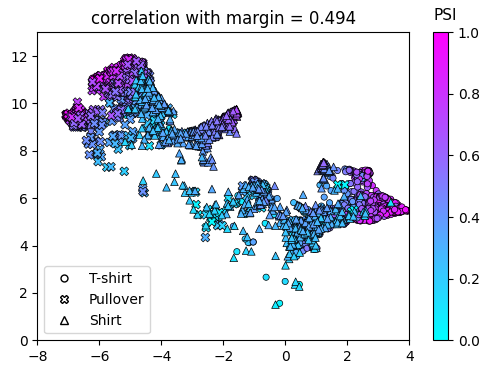

In [8]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,psi)

umap_result = np.load(f'{exp_name}/umap.npy')

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=psi_class[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=psi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=psi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('PSI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

In [13]:
rank_psi_class = []
for k in range(10):
    psi = psi_class[:,k]
    idx_sort = np.argsort(np.argsort(psi))
    rank_psi = idx_sort/(len(psi)-1)
    rank_psi_class.append(rank_psi)

rank_psi_class = np.array(rank_psi_class).T
rank_psi = [psi_value[pred_value] for psi_value, pred_value in zip(rank_psi_class, pred_y)]

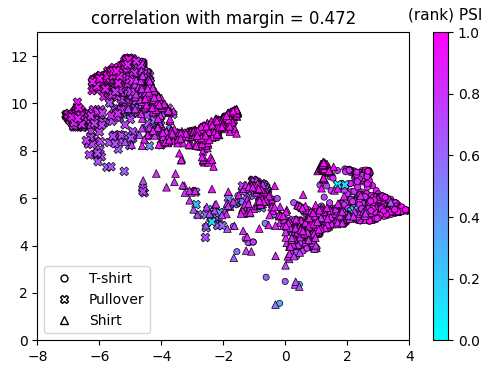

In [14]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_psi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 0
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_psi_class[idx,k], marker='o', cmap=cp)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_psi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_psi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='T-shirt', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Pullover', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Shirt', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) PSI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,4)
plt.ylim(0,13)
plt.clim(0,1)

## VGG16, CIFAR10

In [15]:
cfg = { 'dataset' : 'cifar10',
        'model' : 'vgg16',
        'batch_size' : 512,
        'optimizer' : 'Adam',
        'learning_rate' : 0.001,
        'max_epoch' : 300,
        'patience' : 10,}    

model_name = cfg['model']
dataset_name = cfg['dataset']

In [26]:
run = 0
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
activity = int_model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
reducer = umap.UMAP(n_components=2)
umap_result = reducer.fit_transform(activity)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
np.save(f'{exp_name}/umap.npy', umap_result)

In [ ]:
run = 0
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
umap_result = np.load(f'{exp_name}/umap.npy')

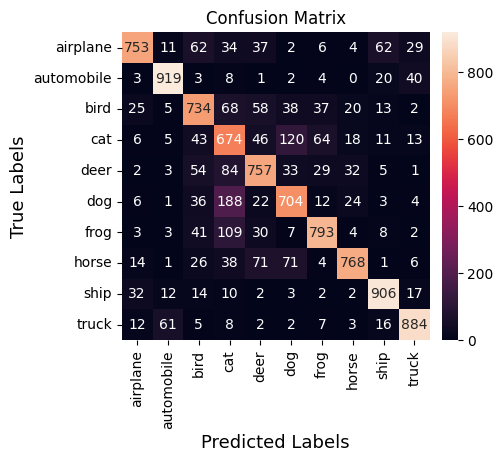

In [12]:
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
cm = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 4), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', square=True, cbar_kws={"pad": 0.02})
plt.xlabel('Predicted Labels', fontsize=13)
plt.ylabel('True Labels', fontsize=13)
class_names = ds_info.features['label'].names
plt.xticks(ticks=np.array(range(len(class_names)))+0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.array(range(len(class_names)))+0.5, labels=class_names, rotation=0)
plt.title('Confusion Matrix')
plt.show()

In [13]:
wrong_preds = np.sum(cm, axis=1) - np.diag(cm)
wrong_preds

array([247,  81, 266, 326, 243, 296, 207, 232,  94, 116])

In [7]:
margin_list = []
for x, y in ds_test.batch(512):
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        h_i = tf.reduce_max(logits, axis=1)
    grad_i = tape.gradient(h_i, x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        h_j = tf.convert_to_tensor([tf.math.top_k(logit, 2).values[1] for logit in logits])
    grad_j = tape.gradient(h_j, x)

    margin = (h_i - h_j) / np.linalg.norm(grad_i - grad_j)
    margin_list.extend(list(margin.numpy()))

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
np.save(f'{exp_name}/margin.npy', np.array(margin_list))

### Softmax

In [14]:
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
softmax_val = np.max(preds, axis=1)

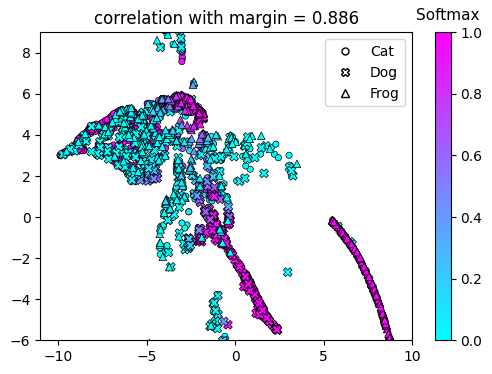

In [32]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,softmax_val)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=preds[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=preds[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=preds[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('Softmax', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

In [33]:
rank_preds = []
for k in range(10):
    softmax_ = preds[:,k]
    idx_sort = np.argsort(np.argsort(softmax_))
    rank_softmax = idx_sort/(len(softmax_)-1)
    rank_preds.append(rank_softmax)
    
rank_preds = np.array(rank_preds).T
rank_softmax = [softmax_value[pred_value] for softmax_value, pred_value in zip(rank_preds, pred_y)]

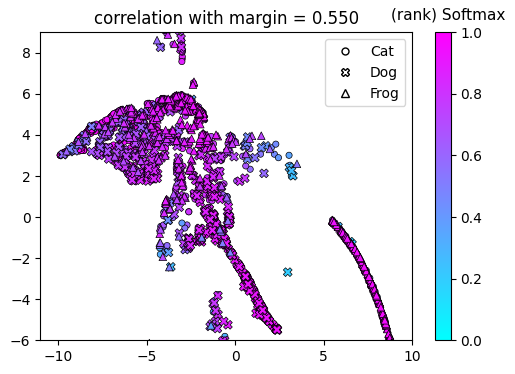

In [37]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_softmax)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_preds[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_preds[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_preds[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('(rank) Softmax', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

### PMI

In [39]:
critic = 'separable'
estimator = 'density_ratio_fitting'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
pmi_class = np.load(f'{exp_name}/pmi_class_test.npy')
pmi_class = np.array([softmax(x) for x in pmi_class])
pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(pmi_class, pred_y)]

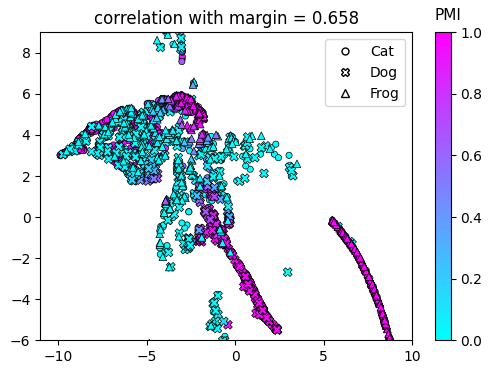

In [41]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,pmi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=pmi_class[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=pmi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=pmi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('PMI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

In [42]:
rank_pmi_class = []
for k in range(10):
    pmi = pmi_class[:,k]
    idx_sort = np.argsort(np.argsort(pmi))
    rank_pmi = idx_sort/(len(pmi)-1)
    rank_pmi_class.append(rank_pmi)

rank_pmi_class = np.array(rank_pmi_class).T
rank_pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(rank_pmi_class, pred_y)]

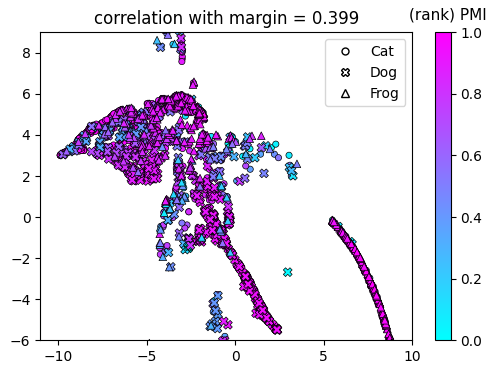

In [44]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_pmi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_pmi_class[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_pmi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_pmi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('(rank) PMI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

### PVI

In [16]:
estimator = 'ensemble_training_from_scratch_training_mlp_penultimate'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pvi/{estimator}'
pvi_class = np.load(f'{exp_name}/pvi_class_test.npy')
pvi_class = np.array([softmax(x) for x in pvi_class])
pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(pvi_class, pred_y)]

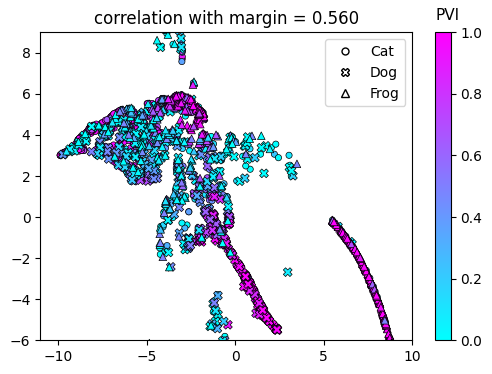

In [17]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,pvi)

umap_result = np.load(f'{exp_name}/umap.npy')

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=pvi_class[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=pvi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=pvi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('PVI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

In [18]:
rank_pvi_class = []
for k in range(10):
    pvi = pvi_class[:,k]
    idx_sort = np.argsort(np.argsort(pvi))
    rank_pvi = idx_sort/(len(pvi)-1)
    rank_pvi_class.append(rank_pvi)

rank_pvi_class = np.array(rank_pvi_class).T
rank_pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(rank_pvi_class, pred_y)]

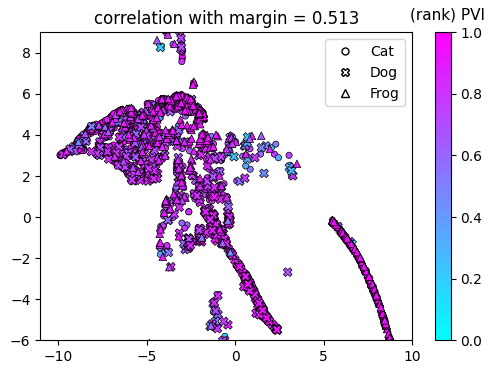

In [20]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_pvi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_pvi_class[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_pvi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_pvi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('(rank) PVI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

### PSI

In [21]:
estimator = 'gaussian'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/psi/{estimator}'
psi_class = np.load(f'{exp_name}/psi_class_test.npy')
psi_class = np.array([softmax(x) for x in psi_class])
psi = [psi_value[pred_value] for psi_value, pred_value in zip(psi_class, pred_y)]

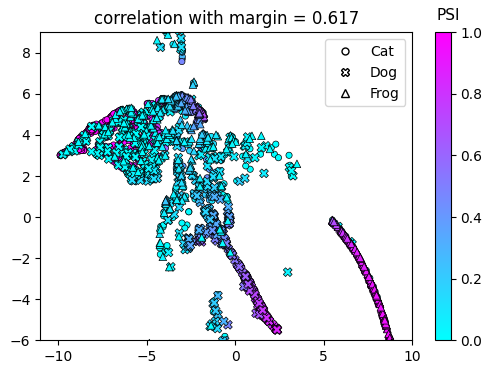

In [22]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,psi)

umap_result = np.load(f'{exp_name}/umap.npy')

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=psi_class[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=psi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=psi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('PSI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

In [24]:
rank_psi_class = []
for k in range(10):
    psi = psi_class[:,k]
    idx_sort = np.argsort(np.argsort(psi))
    rank_psi = idx_sort/(len(psi)-1)
    rank_psi_class.append(rank_psi)

rank_psi_class = np.array(rank_psi_class).T
rank_psi = [psi_value[pred_value] for psi_value, pred_value in zip(rank_psi_class, pred_y)]

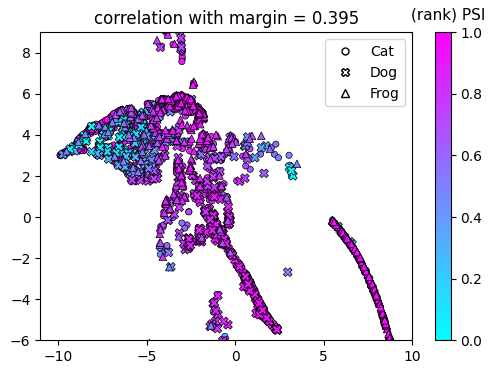

In [25]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_psi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_psi_class[idx,k], marker='o', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_psi_class[idx,k], marker='X', cmap=cp)

k = 6
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_psi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='Cat', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='Dog', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='Frog', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='upper right')
clb = plt.colorbar()
clb.set_label('(rank) PSI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-11,10)
plt.ylim(-6,9)
plt.clim(0,1)

## DenseNet121, SVHN

In [30]:
cfg = { 'dataset' : 'svhn',
        'model' : 'densenet121',
        'batch_size' : 512,
        'optimizer' : 'Adam',
        'learning_rate' : 0.001,
        'max_epoch' : 300,
        'patience' : 10,}    

model_name = cfg['model']
dataset_name = cfg['dataset']

In [46]:
run = 0
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
activity = int_model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
reducer = umap.UMAP(n_components=2)
umap_result = reducer.fit_transform(activity)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
np.save(f'{exp_name}/umap.npy', umap_result)

In [ ]:
run = 0
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
umap_result = np.load(f'{exp_name}/umap.npy')

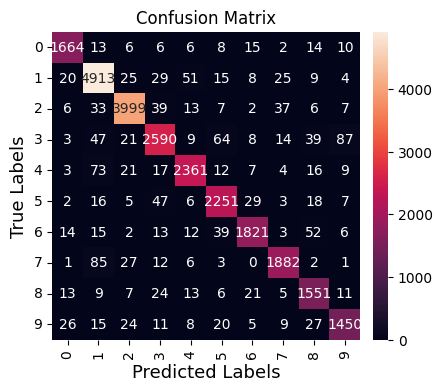

In [47]:
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)
cm = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 4), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', square=True, cbar_kws={"pad": 0.02})
plt.xlabel('Predicted Labels', fontsize=13)
plt.ylabel('True Labels', fontsize=13)
class_names = ds_info.features['label'].names
plt.xticks(ticks=np.array(range(len(class_names)))+0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.array(range(len(class_names)))+0.5, labels=class_names, rotation=0)
plt.title('Confusion Matrix')
plt.show()

In [48]:
wrong_preds = np.sum(cm, axis=1) - np.diag(cm)
wrong_preds

array([ 80, 186, 150, 292, 162, 133, 156, 137, 109, 145])

In [54]:
margin_list = []
for x, y in ds_test.batch(512):
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        h_i = tf.reduce_max(logits, axis=1)
    grad_i = tape.gradient(h_i, x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x)
        h_j = tf.convert_to_tensor([tf.math.top_k(logit, 2).values[1] for logit in logits])
    grad_j = tape.gradient(h_j, x)

    margin = (h_i - h_j) / np.linalg.norm(grad_i - grad_j)
    margin_list.extend(list(margin.numpy()))

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
np.save(f'{exp_name}/margin.npy', np.array(margin_list))

### Softmax

In [49]:
ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
preds = model.predict(ds_test.batch(cfg['batch_size']), verbose=0)
softmax_val = np.max(preds, axis=1)

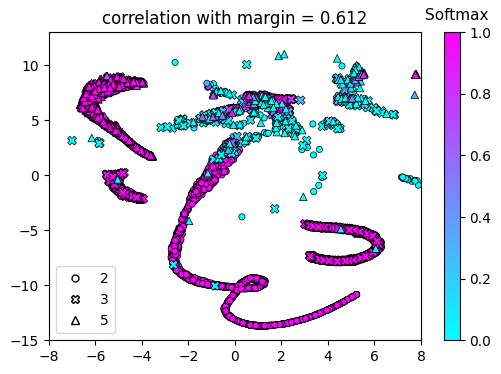

In [55]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,softmax_val)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=preds[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=preds[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=preds[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('Softmax', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

In [56]:
rank_preds = []
for k in range(10):
    softmax_ = preds[:,k]
    idx_sort = np.argsort(np.argsort(softmax_))
    rank_softmax = idx_sort/(len(softmax_)-1)
    rank_preds.append(rank_softmax)
    
rank_preds = np.array(rank_preds).T
rank_softmax = [softmax_value[pred_value] for softmax_value, pred_value in zip(rank_preds, pred_y)]

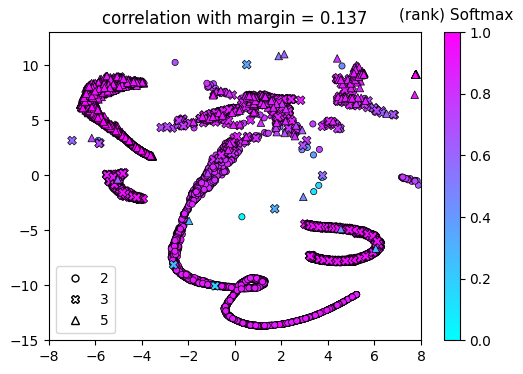

In [57]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_softmax)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_preds[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_preds[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_preds[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) Softmax', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

### PMI

In [58]:
critic = 'separable'
estimator = 'density_ratio_fitting'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pmi/{critic}_{estimator}'
pmi_class = np.load(f'{exp_name}/pmi_class_test.npy')
pmi_class = np.array([softmax(x) for x in pmi_class])
pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(pmi_class, pred_y)]

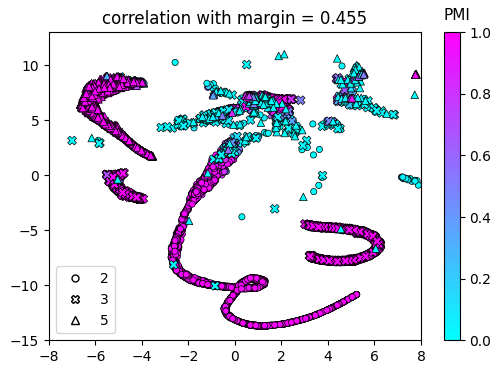

In [61]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,pmi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=pmi_class[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=pmi_class[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=pmi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('PMI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

In [62]:
rank_pmi_class = []
for k in range(10):
    pmi = pmi_class[:,k]
    idx_sort = np.argsort(np.argsort(pmi))
    rank_pmi = idx_sort/(len(pmi)-1)
    rank_pmi_class.append(rank_pmi)

rank_pmi_class = np.array(rank_pmi_class).T
rank_pmi = [pmi_value[pred_value] for pmi_value, pred_value in zip(rank_pmi_class, pred_y)]

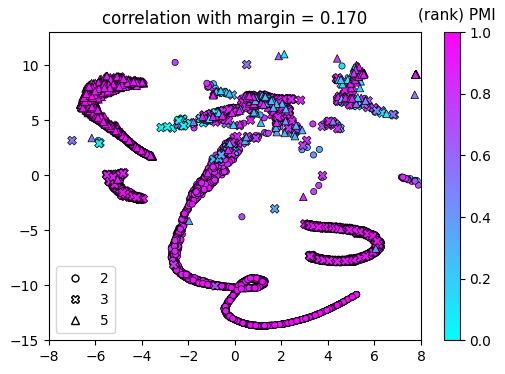

In [63]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_pmi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_pmi_class[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_pmi_class[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_pmi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) PMI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

### PVI

In [31]:
estimator = 'ensemble_training_from_scratch_training_mlp_penultimate'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/pvi/{estimator}'
pvi_class = np.load(f'{exp_name}/pvi_class_test.npy')
pvi_class = np.array([softmax(x) for x in pvi_class])
pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(pvi_class, pred_y)]

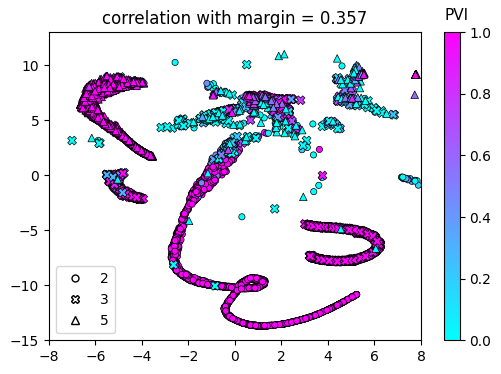

In [32]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,pvi)

umap_result = np.load(f'{exp_name}/umap.npy')

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=pvi_class[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=pvi_class[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=pvi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('PVI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

In [33]:
rank_pvi_class = []
for k in range(10):
    pvi = pvi_class[:,k]
    idx_sort = np.argsort(np.argsort(pvi))
    rank_pvi = idx_sort/(len(pvi)-1)
    rank_pvi_class.append(rank_pvi)

rank_pvi_class = np.array(rank_pvi_class).T
rank_pvi = [pvi_value[pred_value] for pvi_value, pred_value in zip(rank_pvi_class, pred_y)]

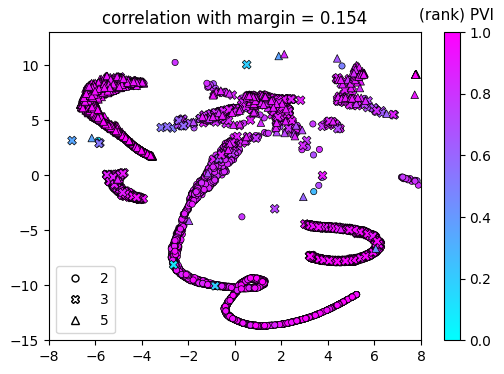

In [34]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_pvi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_pvi_class[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_pvi_class[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_pvi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) PVI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

### PSI

In [36]:
estimator = 'gaussian'
run = 0

ds_train, ds_val, ds_test, ds_info = load_dataset(cfg, shuffle=False)
n_classes = ds_info.features['label'].num_classes
ds_test = preprocess_dataset(ds_test, cfg, n_classes, resize=False, normalize=True, onehot=True)
model = tf.keras.models.load_model(f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/trained_model.keras')
true_y = np.argmax([y for x,y in ds_test], axis=1)
pred_y = np.argmax(model.predict(ds_test.batch(cfg['batch_size']), verbose=0), axis=1)

exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration/psi/{estimator}'
psi_class = np.load(f'{exp_name}/psi_class_test.npy')
psi_class = np.array([softmax(x) for x in psi_class])
psi = [psi_value[pred_value] for psi_value, pred_value in zip(psi_class, pred_y)]

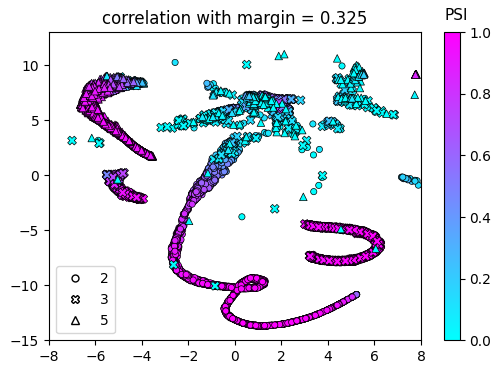

In [37]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,psi)

umap_result = np.load(f'{exp_name}/umap.npy')

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=psi_class[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=psi_class[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=psi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('PSI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)

In [38]:
rank_psi_class = []
for k in range(10):
    psi = psi_class[:,k]
    idx_sort = np.argsort(np.argsort(psi))
    rank_psi = idx_sort/(len(psi)-1)
    rank_psi_class.append(rank_psi)

rank_psi_class = np.array(rank_psi_class).T
rank_psi = [psi_value[pred_value] for psi_value, pred_value in zip(rank_psi_class, pred_y)]

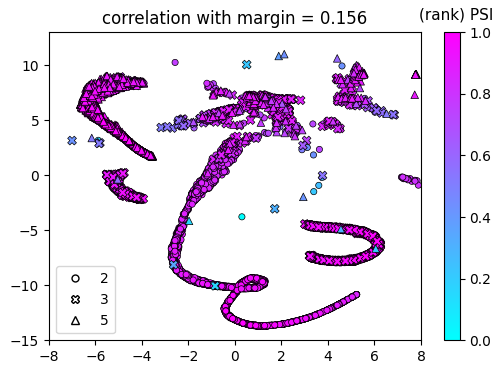

In [39]:
exp_name = f'../results/PI_Explainability/{model_name}_{dataset_name}/run_{run+1}/calibration'
margin = np.load(f'{exp_name}/margin.npy')
corr_coeff, _ = pearsonr(margin,rank_psi)

plt.figure(figsize=(6,4),dpi=100)
cp = sns.color_palette('cool', as_cmap=True)

k = 2
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=20, lw=0.5, c=rank_psi_class[idx,k], marker='o', cmap=cp)

k = 3
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=40, lw=0.5, c=rank_psi_class[idx,k], marker='X', cmap=cp)

k = 5
idx = np.where(true_y == k)[0]
plt.scatter(umap_result[idx, 0], umap_result[idx, 1], edgecolors='k', s=30, lw=0.5, c=rank_psi_class[idx,k], marker='^', cmap=cp)

line_1 = mpl.lines.Line2D([], [], color='none', marker='o', markeredgecolor='k', lw=0.5, label='2', markersize=5)
line_2 = mpl.lines.Line2D([], [], color='none', marker='X', markeredgecolor='k', lw=0.5, label='3', markersize=6)
line_3 = mpl.lines.Line2D([], [], color='none', marker='^', markeredgecolor='k', lw=0.5, label='5', markersize=6)
plt.legend(handles=[line_1, line_2, line_3], loc='lower left')
clb = plt.colorbar()
clb.set_label('(rank) PSI', labelpad=-25, y=1.08, rotation=0, fontsize=11)
plt.title(f'correlation with margin = {corr_coeff:.3f}')
plt.xlim(-8,8)
plt.ylim(-15,13)
plt.clim(0,1)